In [1]:
import torch
from torch import ones, zeros, tensor, eye

from torch.distributions import Categorical

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style='white', palette='colorblind', color_codes=True)

import sys
import os

import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/control_dilemmas')])

from befit.simulate import Simulator
from befit.tasks import bandits
from befit.agents import AIBanditsNaive, AIBanditsFlat, Random

from setup_environment import *

In [2]:
# Define environment
context = torch.from_numpy(np.load('context.npy'))
offers = torch.from_numpy(np.load('offers.npy'))

envs = []
for i in range(5):
    envs.append(bandits.MultiArmedBandit(priors, 
                                         transitions, 
                                         context,
                                         offers,
                                         arm_types,
                                         nsub=nsub, 
                                         blocks=blocks, 
                                         trials=trials))

# Define agents
lam = torch.tensor([1.])

pars = {
    'ns': 4,  # number of arms
    'na': na,  # number of actions
    'nf': nf,  # number of features
    'ni': len(lam),  # internal states change preference over features, for now they match number of features
}

a = 2*torch.stack([torch.eye(nf), torch.eye(nf)]).reshape(-1, 3)[arm_types] + 1
a = a.repeat(nsub, 1, 1, 1)

naive_ev_agent = AIBanditsNaive(pars, runs=nsub, blocks=blocks, trials=trials)
naive_ev_agent.set_parameters(depth=trials, lam=lam)

naive_iv_agent = AIBanditsNaive(pars, runs=nsub, blocks=blocks, trials=trials)
naive_iv_agent.set_parameters(epistemic=False, depth=trials, lam=lam)

pars = {
    'nd': 10,
    'ns': 4,  # number of arm types
    'na': na,
    'nc': 6,  # number of contexts
    'nf': nf,
    'ni': len(lam),  # internal states change preference over features, for now they match number of features
}

nd = 10
Bdd = zeros(nd, nd)

d = torch.arange(1., nd+1.)
m = 10.
s = 5.
Bdd[0] = (-(d.log()-m)**2/s - d.log() ).softmax(-1)
Bdd[range(1, nd), range(nd-1)] = 1.

Bccd = zeros(nd, 6, 6)
Bccd[0] = (ones(6, 6) - eye(6))/5
Bccd[1:] = eye(6).repeat(nd-1, 1, 1)

tm_higher = {
    'context': Bccd,
    'duration': Bdd
}

flat_ev_agent = AIBanditsFlat(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher})
flat_ev_agent.set_parameters(x = [a], depth=trials, lam=lam)

flat_iv_agent = AIBanditsFlat(pars, runs=nsub, blocks=blocks, trials=trials, tm={'higher':tm_higher})
flat_iv_agent.set_parameters(x = [a], epistemic=False, depth=trials, lam=lam)

random_agent = Random(pars, runs=nsub, blocks=blocks, trials=trials)

In [3]:
agents = [naive_ev_agent, naive_iv_agent, flat_ev_agent, flat_iv_agent, random_agent]

sim = Simulator(envs, agents, runs=nsub, blocks=blocks, trials=trials)
sim.simulate_experiment()

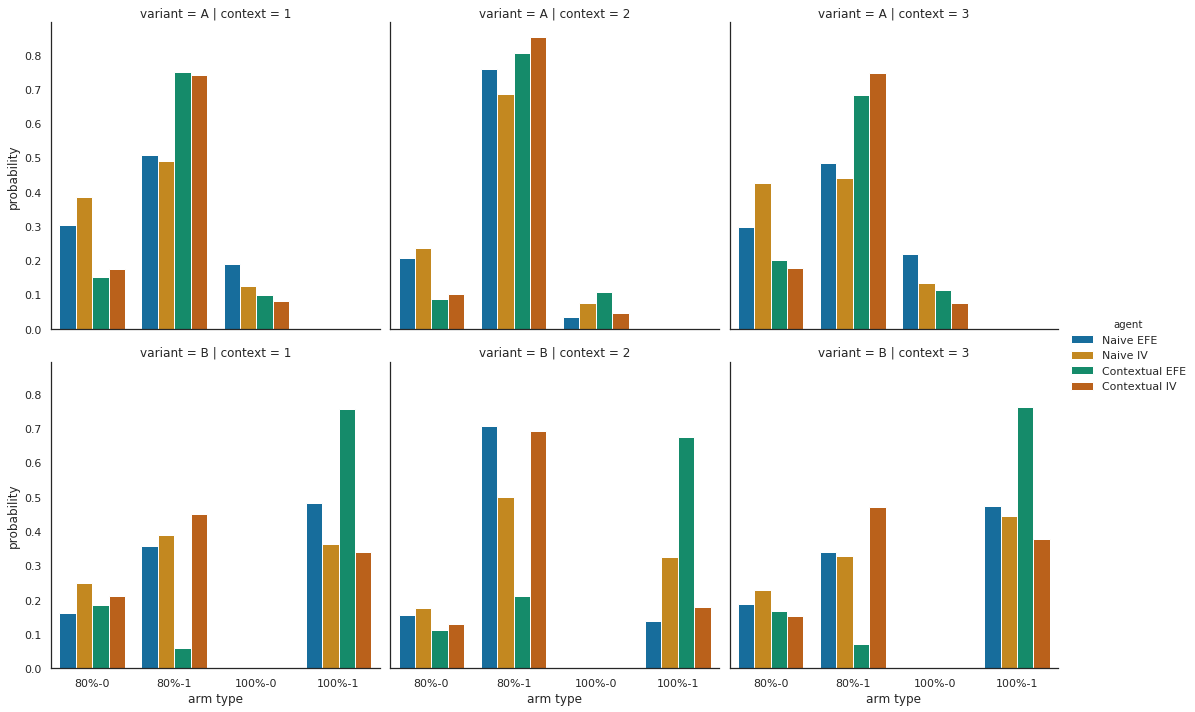

In [4]:
import pandas as pd

offs = offers[100:, 0]

ctxt = [1, 1, 2, 2, 3, 3]
tp = ['A', 'B', 'A', 'B', 'A', 'B']
name = ['Naive EFE', 'Naive IV', 'Contextual EFE', 'Contextual IV']
labels = np.array(['80%-0', '80%-1', '100%-0', '100%-1'])
groups = torch.tensor([0, 1, 1, 2, 3, 3])

dfs = pd.DataFrame()
for i in range(2):
    for j in range(2):
        l = 2 * i + j
        
        responses = []
        for res in sim.responses['pair_{}'.format(l)]:
            responses.append(torch.stack(res[1:]))

        responses = torch.stack(responses[100:])
        choices = arm_types[:, responses].transpose(dim0=-1, dim1=-2)
        
        for o in range(no):
            loc = o == offs
            vals, count = np.unique(groups[choices[o, loc]], return_counts=True)
            df = pd.DataFrame({'arm type': labels[vals], 
                               'probability': count/count.sum(), 
                               'context': ctxt[o], 
                               'variant': tp[o],
                               'agent': name[l]})
            dfs = dfs.append(df, ignore_index=True)
            
sns.catplot(x='arm type', y='probability', data=dfs, col='context', row='variant', hue='agent', kind="bar")
plt.savefig('choice_rates.png', bbox_inches='tight', transparent=True, dpi=300)

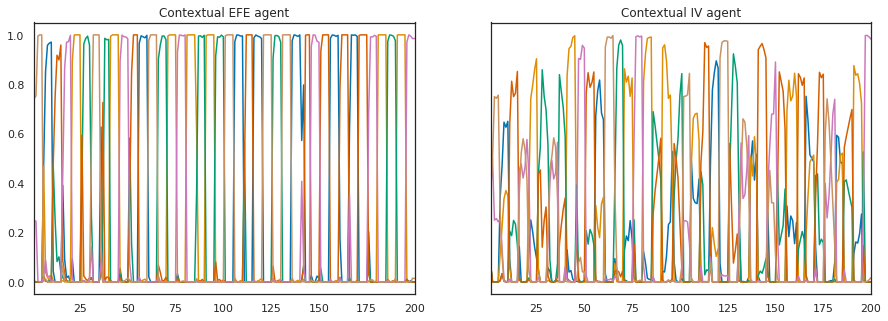

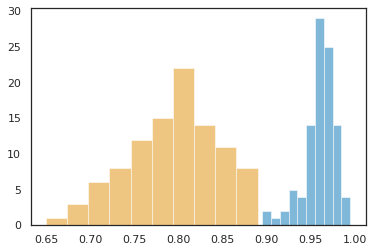

In [7]:
# EV agent is more accurate in estimating current context

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex = True, sharey=True)

sub = 0
axes[0].plot(np.arange(1, blocks+1), flat_ev_agent.beliefs['context'][:, sub].numpy());
axes[0].set_title('Contextual EFE agent');
axes[0].set_xlim([1, blocks])
corr1 = flat_ev_agent.beliefs['context'].argmax(-1) == offers[:, 0]

sub = 0
axes[1].plot(np.arange(1, blocks+1), flat_iv_agent.beliefs['context'][:, sub].numpy());
axes[1].set_title('Contextual IV agent');
axes[1].set_xlim([1, blocks])
corr2 = flat_iv_agent.beliefs['context'].argmax(-1) == offers[:, 0]


plt.figure()
plt.hist(corr1.float().mean(0), alpha=.5);
plt.hist(corr2.float().mean(0), alpha=.5);

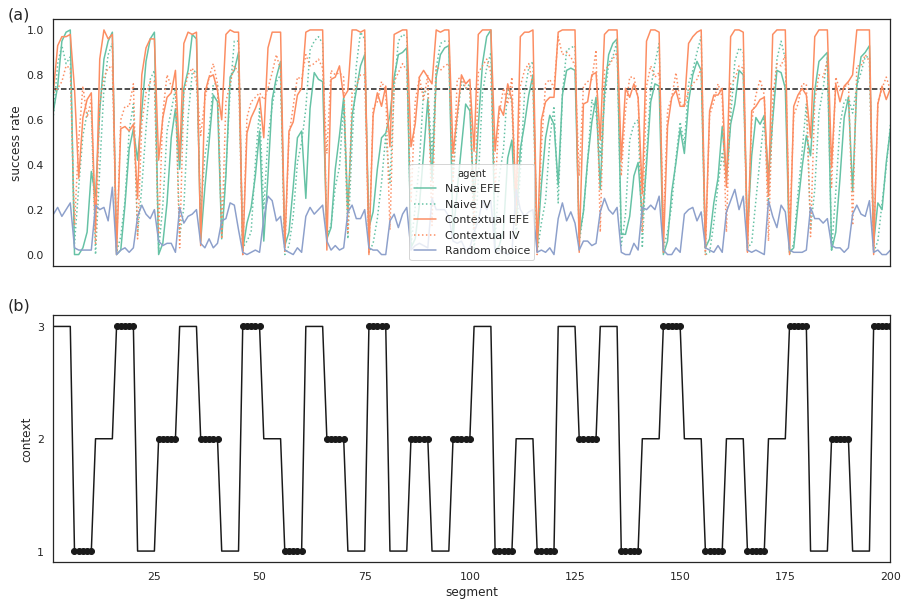

In [33]:
successes = []

out = []
for i in range(5):
    out.append(sim.stimuli['pair_{}'.format(i)]['outcomes'])

for out1, out2, out3, out4, out7 in zip(*out):
    successes.append(torch.stack([out1[-1][-1], 
                                  out2[-1][-1], 
                                  out3[-1][-1], 
                                  out4[-1][-1], 
                                  out7[-1][-1]], 
                                 -1))
    
successes = torch.stack(successes).float()

maximum = rho**trials + rho**(trials - 1)*(1-rho)*trials

N = nsub//3
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
blks = torch.arange(1, blocks + 1).numpy()
axes[0].plot(blks, successes[..., -5].mean(-1).numpy(), c = colors[0], label='Naive EFE');
axes[0].plot(blks, successes[..., -4].mean(-1).numpy(), c = colors[0], linestyle=':', label='Naive IV');
axes[0].plot(blks, successes[..., -3].mean(-1).numpy(), c = colors[1], label='Contextual EFE');
axes[0].plot(blks, successes[..., -2].mean(-1).numpy(), c = colors[1], linestyle=':', label='Contextual IV');
axes[0].plot(blks, successes[..., -1].mean(-1).numpy(), c = colors[2], label='Random choice');

axes[0].hlines(maximum, 1, blocks, 'k', linestyle='--')
axes[0].set_ylabel('success rate')
axes[0].legend(loc=8, title='agent')

offs = offers[:,0,0]
offs = ((offs == 0) + (offs == 4) + (offs == 2)).float()
locs = offs == 1

axes[1].plot(blks, context + 1, 'k');
axes[1].plot(blks[locs], context[locs] + 1, 'ko')
axes[1].set_ylabel('context')
axes[1].set_yticks([1, 2, 3])
axes[1].set_xlabel('segment')

axes[0].text(-10, 1.05, '(a)', fontsize=16)
axes[1].text(-10, 3.15, '(b)', fontsize=16)


plt.xlim([1, blocks]);

fig.savefig('success_rates.png', bbox_inches='tight', transparent=True, dpi=300)

tensor(0.9416)


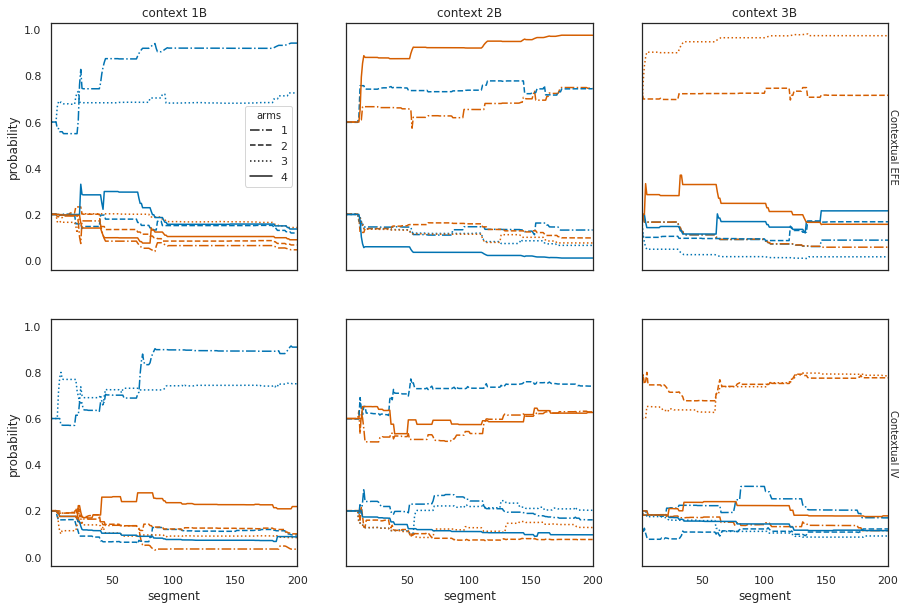

In [10]:
import matplotlib.lines as lns

styles = [lns.Line2D([], [], color='k', linestyle='-.', label='1'),
          lns.Line2D([], [], color='k', linestyle='--', label='2'),
          lns.Line2D([], [], color='k', linestyle=':', label='3'), 
          lns.Line2D([], [], color='k', label='4')]

fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

sub = 1
a1 = torch.stack(flat_ev_agent.a)[1:].reshape(blocks, trials, nsub, 6, 4, nf)
A1 = a1/a1.sum(-1, keepdim=True)

a2 = torch.stack(flat_iv_agent.a)[1:].reshape(blocks, trials, nsub, 6, 4, nf)
A2 = a2/a2.sum(-1, keepdim=True)

t = np.arange(1, blocks+1)

for i,c in enumerate([1, 3, 5]):
    axes[0, i].plot(t, A1[:, -1, sub, c, 0, 1].numpy(), 'b-.');
    axes[0, i].plot(t, A1[:, -1, sub, c, 0, 2].numpy(), 'r-.');
    axes[0, i].plot(t, A1[:, -1, sub, c, 1, 1].numpy(), 'b--');
    axes[0, i].plot(t, A1[:, -1, sub, c, 1, 2].numpy(), 'r--');
    axes[0, i].plot(t, A1[:, -1, sub, c, 2, 1].numpy(), 'b:');
    axes[0, i].plot(t, A1[:, -1, sub, c, 2, 2].numpy(), 'r:');
    axes[0, i].plot(t, A1[:, -1, sub, c, 3, 1].numpy(), 'b');
    axes[0, i].plot(t, A1[:, -1, sub, c, 3, 2].numpy(), 'r');
    axes[0, i].set_title('context {}B'.format(i+1));
    
    a = torch.stack(flat_iv_agent.a)[1:].reshape(blocks, trials, nsub, 6, 4, nf)
    A = a/a.sum(-1, keepdim=True)

    axes[1, i].plot(t, A2[:, -1, sub, c, 0, 1].numpy(), 'b-.');
    axes[1, i].plot(t, A2[:, -1, sub, c, 0, 2].numpy(), 'r-.');
    axes[1, i].plot(t, A2[:, -1, sub, c, 1, 1].numpy(), 'b--');
    axes[1, i].plot(t, A2[:, -1, sub, c, 1, 2].numpy(), 'r--');
    axes[1, i].plot(t, A2[:, -1, sub, c, 2, 1].numpy(), 'b:');
    axes[1, i].plot(t, A2[:, -1, sub, c, 2, 2].numpy(), 'r:');
    axes[1, i].plot(t, A2[:, -1, sub, c, 3, 1].numpy(), 'b');
    axes[1, i].plot(t, A2[:, -1, sub, c, 3, 2].numpy(), 'r');

axes[0, 0].legend(handles=styles, title='arms');
axes[-1, -1].set_xlim([1, blocks])
axes[-1, 0].set_xlabel('segment')
axes[-1, -2].set_xlabel('segment')
axes[-1, -1].set_xlabel('segment')

axes[0, 0].set_ylabel('probability')
axes[1, 0].set_ylabel('probability')

axes[0, -1].text(1.02, .5, 'Contextual EFE', 
                 horizontalalignment='center',
                 verticalalignment='center',
                 rotation=-90,
                 transform=axes[0, -1].transAxes )

axes[1, -1].text(1.02, .5, 'Contextual IV', 
                 horizontalalignment='center',
                 verticalalignment='center',
                 rotation=-90,
                 transform=axes[1, -1].transAxes )

plt.savefig('reward_probs.png', bbox_inches='tight', transparent=True, dpi=600)



In [15]:
print(A1[-1, -1, sub, 1, 0, 1], A1[-1, -1, sub, 3, 3, 2], A1[-1, -1, sub, 5, 2, 2])

tensor(0.9416) tensor(0.9756) tensor(0.9736)


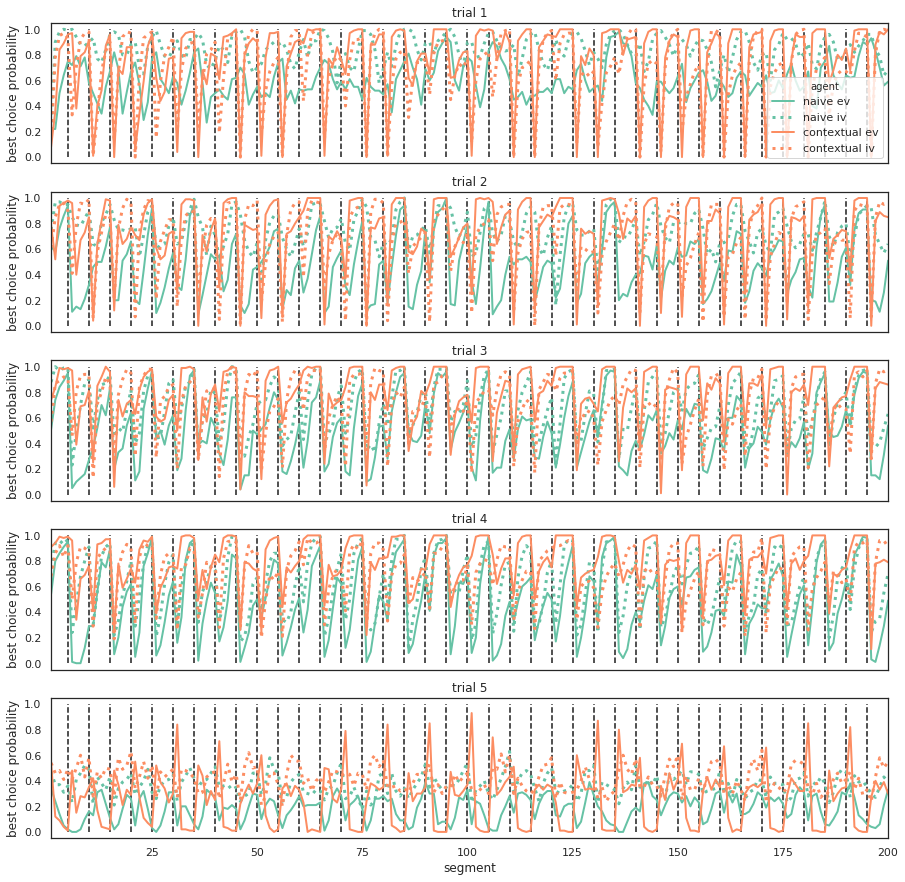

In [7]:
comp = []
for i, agent in enumerate(agents):
    if i == len(agents) - 1:
        break
    
    if i < 2:
        a = torch.stack(agent.a).reshape(blocks, trials + 1, nsub, 4, nf)
    else:
        a = torch.stack(agent.a)[:-1].reshape(blocks, trials, nsub, 6, 4, nf)
        
    A = a/a.sum(-1, keepdim=True)
    value, loc = A[..., 1:].max(-1)
    value, actions = value.max(-1)
    
    res = []
    for r in sim.responses['pair_{}'.format(i)]:
        res.append(torch.stack(r[1:]))
    res = torch.stack(res)
    
    if i < 2:
        comp.append(res == actions[:, :-1])
    else:
        comp.append(res == actions[range(blocks), :, :, offers[:, 0, 0]])

segs = np.arange(1, blocks + 1)
fig, axes = plt.subplots(trials, 1, figsize=(15, 15), sharex=True, sharey=True)
for t in range(trials):
    axes[t].plot(segs, comp[0].float().mean(-1)[:, t].numpy(), colors[0], lw=2, label='naive ev');
    axes[t].plot(segs, comp[1].float().mean(-1)[:, t].numpy(), colors[0], linestyle=':', lw=3, label='naive iv');
    axes[t].plot(segs, comp[2].float().mean(-1)[:, t].numpy(), colors[1], lw=2, label='contextual ev');
    axes[t].plot(segs, comp[3].float().mean(-1)[:, t].numpy(), colors[1], linestyle=':', lw=3, label='contextual iv');
    axes[t].vlines(np.arange(5, blocks, 5), 0., 1., 'k', linestyle='--');
    axes[t].set_ylabel('best choice probability');
    axes[t].set_title('trial {}'.format(t+1))

axes[-1].set_xlabel('segment');
axes[-1].set_xlim([1, blocks]);
axes[0].legend(title='agent')

fig.savefig('best_choice.png', transparent=True, bbox_inches='tight', dpi=600)

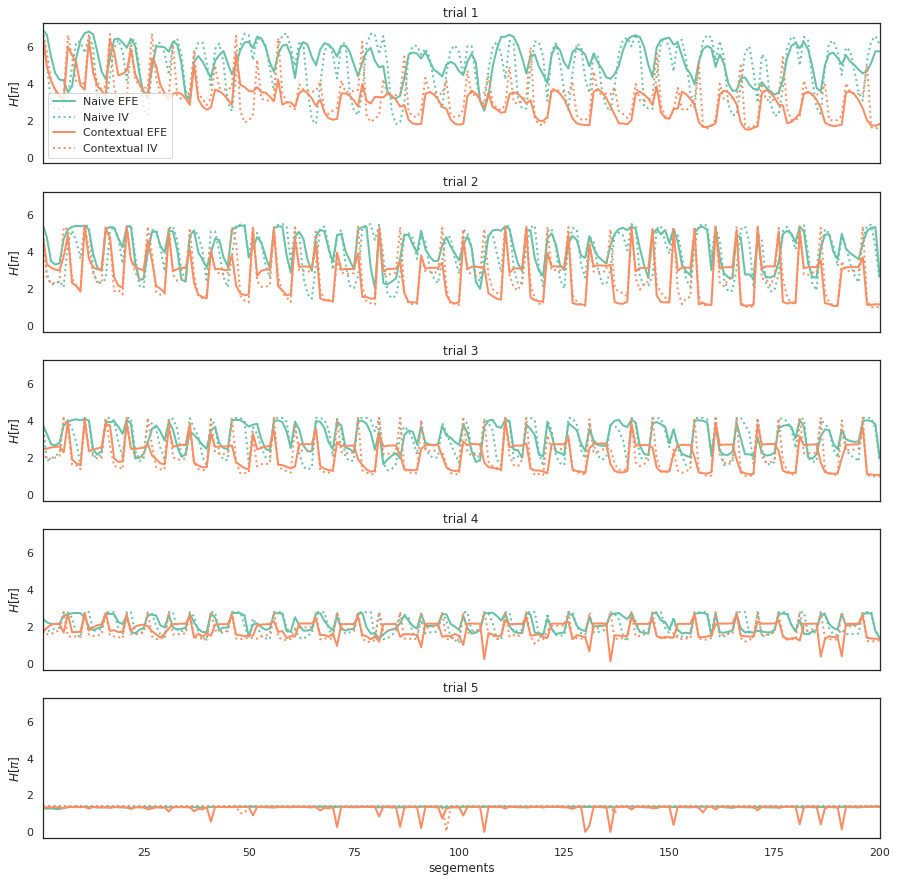

In [8]:
q_pi_evn = torch.einsum('btnip,bni->btnp',
                        naive_ev_agent.beliefs['policies'],
                        naive_ev_agent.beliefs['internals'])
q_pi_ivn = torch.einsum('btnip,bni->btnp',
                        naive_iv_agent.beliefs['policies'],
                        naive_iv_agent.beliefs['internals']) 
q_pi_evf = torch.einsum('btnip,bni->btnp',
                        flat_ev_agent.beliefs['policies'],
                        flat_ev_agent.beliefs['internals']) 
q_pi_ivf = torch.einsum('btnip,bni->btnp',
                        flat_iv_agent.beliefs['policies'],
                        flat_iv_agent.beliefs['internals']) 

evn_H_pi = - np.nan_to_num(q_pi_evn * q_pi_evn.log()).sum(-1)
ivn_H_pi = - np.nan_to_num(q_pi_ivn * q_pi_ivn.log()).sum(-1)
evf_H_pi = - np.nan_to_num(q_pi_evf * q_pi_evf.log()).sum(-1)
ivf_H_pi = - np.nan_to_num(q_pi_ivf * q_pi_ivf.log()).sum(-1)

fig, axes = plt.subplots(trials, 1, figsize=(15,15), sharex=True, sharey=True)
segs = np.arange(1, blocks+1)
for t in range(trials):
#     axes[t].vlines(np.arange(20, 240, 20), 1, 5, 'k', linestyle='--', lw=3)
    axes[t].plot(segs, np.median(evn_H_pi, -1)[:, t], colors[0], lw=2, label='Naive EFE');
    axes[t].plot(segs, np.median(ivn_H_pi, -1)[:, t], colors[0], linestyle=':', lw=2, label='Naive IV');
    axes[t].plot(segs, np.median(evf_H_pi, -1)[:, t], colors[1], lw=2, label='Contextual EFE');
    axes[t].plot(segs, np.median(ivf_H_pi, -1)[:, t], colors[1], linestyle=':', lw=2, label='Contextual IV');
#     axes[t].vlines(np.arange(6, blocks, 5), 0., 6., 'k', linestyle='--');
    axes[t].set_ylabel(r'$H[\pi]$')
    axes[t].set_title('trial {}'.format(t+1))

axes[0].legend();
axes[0].set_xlim([1, blocks])
axes[-1].set_xlabel('segements')

fig.savefig('entropy.png', bbox_inches='tight', transparent=True, dpi=300)